# Pytorch Cheatsheet

## Imports

In [306]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as tv_utils
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from PIL import Image
import imp
import os
import sys
import math
import time
import random
import shutil
import cv2
import scipy.misc
from glob import glob
import sklearn
import logging

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Basics

* http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
* http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Datasets

## File Management

In [307]:
random.seed(1)
torch.manual_seed(1)
DATA_PATH='/media/bfortuner/bigguy/data/'

# Built-in
MNIST_PATH=DATA_PATH+'mnist/'
MNIST_WEIGHTS_PATH=MNIST_PATH+'weights/'

# Built-in
CIFAR10_PATH=DATA_PATH+'cifar10/'
CIFAR10_IMGS_PATH=CIFAR10_PATH+'images/'

# Download from http://www.vision.caltech.edu/visipedia/CUB-200.html
CUB_PATH=DATA_PATH+'cub/'
CUB_IMGS_PATH=CUB_PATH+'images/'

In [308]:
def get_paths_to_files(dir_path):
    filepaths = []
    fnames = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames if not f[0] == '.')
        fnames.extend([f for f in filenames if not f[0] == '.'])
    return filepaths, fnames

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path)[0]
    return filepaths[random.randrange(len(filepaths))]

## MNIST

In [309]:
MNIST_BATCH_SIZE = 128
MNIST_MEAN = np.array([0.1307,])
MNIST_STD = np.array([0.3081,])
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=True, download=True,
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize(MNIST_MEAN, MNIST_STD)
           ])),
    batch_size=MNIST_BATCH_SIZE, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=False, 
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize(MNIST_MEAN, MNIST_STD)
           ])),
    batch_size=MNIST_BATCH_SIZE*8, shuffle=True)

def get_mnist_batch(batch_size):
    dataloader = torch.utils.data.DataLoader(
        datasets.MNIST(MNIST_PATH, train=False, download=False,
               transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize(MNIST_MEAN, MNIST_STD)
               ])),
        batch_size=batch_size, shuffle=True)
    inputs, targets = next(iter(dataloader))
    return inputs, targets

mnist_train_labels = mnist_train_loader.dataset.train_labels
MNIST_CLASSES = np.unique(mnist_train_labels.numpy())
mnist_batch = get_mnist_batch(100)
print("MNIST Train Samples:", len(mnist_train_loader.dataset))
print("MNIST Test Samples:", len(mnist_test_loader.dataset))

MNIST Train Samples: 60000
MNIST Test Samples: 10000


## CIFAR10

In [368]:
CIFAR_BATCH_SIZE = 64
CIFAR_MEAN = np.array([0.49139968, 0.48215827, 0.44653124])
CIFAR_STD = np.array([0.24703233, 0.24348505, 0.26158768])
normTransform = transforms.Normalize(CIFAR_MEAN, CIFAR_STD)

trainTransform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normTransform
])
testTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform
])

cifar_train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(CIFAR10_IMGS_PATH, train=True, download=True,
                 transform=trainTransform),
    batch_size=CIFAR_BATCH_SIZE, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(CIFAR10_IMGS_PATH, train=False, download=True,
                 transform=testTransform),
    batch_size=CIFAR_BATCH_SIZE*16, shuffle=False)

def get_cifar_batch(batch_size):
    dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10(CIFAR10_IMGS_PATH, train=False, 
         transform=testTransform), batch_size=batch_size, shuffle=True)
    inputs, targets = next(iter(dataloader))
    return inputs, targets

CIFAR_CLASSES = np.unique(np.array(cifar_train_loader.dataset.train_labels))
CIFAR_CLASS_NAMES = np.array(['airplane','automobile','bird','cat',
                          'deer','dog','frog', 'horse','ship','truck'])
cifar_batch = get_cifar_batch(100)
print("CIFAR Train Samples:", len(cifar_train_loader.dataset))
print("CIFAR Test Samples:", len(cifar_test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
CIFAR Train Samples: 50000
CIFAR Test Samples: 10000


## Loading From Image Folders

In [311]:
def get_mean_std_of_dataset(dir_path, sample_size=5):
    fpaths, fnames = get_paths_to_files(dir_path)
    random.shuffle(fpaths)
    total_mean = np.array([0.,0.,0.])
    total_std = np.array([0.,0.,0.]) 
    for f in fpaths[:sample_size]:
        img_arr = load_img_as_np_arr(f)
        mean = np.mean(img_arr, axis=(0,1))
        std = np.std(img_arr, axis=(0,1))
        total_mean += mean
        total_std += std
    avg_mean = total_mean / sample_size
    avg_std = total_std / sample_size
    print("mean: {}".format(avg_mean), "stdev: {}".format(avg_std))
    return avg_mean, avg_std

CUB_BATCH_SIZE = 32
CUB_MEAN, CUB_STD = get_mean_std_of_dataset(CUB_IMAGES_PATH, 1000)

cub_dataset = datasets.ImageFolder(root=CUB_IMAGES_PATH, 
           transform=transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(CUB_MEAN, CUB_STD),
        ]))

def get_cub_batch(batch_size):
    dataloader = torch.utils.data.DataLoader(
        cub_dataset, batch_size=batch_size, shuffle=True)
    inputs, targets = next(iter(dataloader))
    return inputs, targets

cub_data_loader = torch.utils.data.DataLoader(
    cub_dataset, batch_size=CUB_BATCH_SIZE, shuffle=True)
cub_class_names = cub_dataset.classes
cub_batch = get_cub_batch(10)

mean: [ 121.20877038  125.52102772  107.98349568] stdev: [ 48.47773578  48.08521783  51.3832965 ]


## Swiss Roll

torch.Size([100, 2]) torch.Size([100])


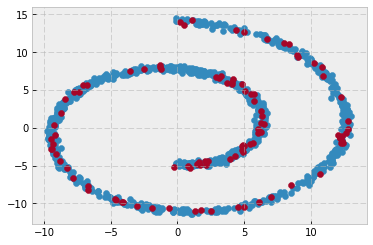

In [312]:
from sklearn.datasets.samples_generator import make_swiss_roll

def get_swiss_roll(n_samples=100):
    noise = 0.2
    X, _ = make_swiss_roll(n_samples, noise)
    X = X.astype('float32')[:, [0, 2]]
    return X, _

def plot_roll(data):
    # data.shape = (N, 2)
    if type(data) != np.ndarray:
        data = data.numpy()
    x = data[:,0]
    y = data[:,1]
    plt.scatter(x,y)

SWISS_ROLL_BATCH_SIZE = 100
X, _ = get_swiss_roll(100)
swiss_roll_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X), torch.FloatTensor(_))
swiss_roll_loader = torch.utils.data.DataLoader(swiss_roll_dataset, batch_size=SWISS_ROLL_BATCH_SIZE, shuffle=True)
    
# Test
data = get_swiss_roll(1000)[0]
plot_roll(data)
inputs,targets = next(iter(swiss_roll_loader))
print(inputs.size(),targets.size())
plot_roll(inputs)

# Image Handling

## Normalization

In [313]:
def norm_meanstd(arr, mean, std):
    return (arr - mean) / std

def denorm_meanstd(arr, mean, std):
    return (arr * std) + mean

def norm255_tensor(arr):
    """Given a color image/where max pixel value in each channel is 255
    returns normalized tensor or array with all values between 0 and 1"""
    return arr / 255.
    
def denorm255_tensor(arr):
    return arr * 255.

## Loading

In [314]:
def load_img_as_pil(img_path):
    return Image.open(img_path)

def load_img_as_np_arr(img_path):
    return scipy.misc.imread(img_path) #scipy

def load_img_as_tensor(img_path):
    pil_image = Image.open(img_path)
    return transforms.ToTensor()(pil_image)

## Saving

In [315]:
def save_tensor_img(tns, fpath):
    tv_utils.save_image(tns, fpath)
    
def save_pil_img(pil_img, fpath):
    pil_img.save(fpath)
    
def save_numpy_img(np_arr, fpath):
    scipy.misc.imsave(fpath, np_arr)

## Plotting

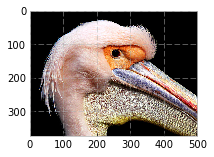

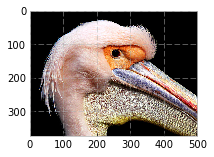

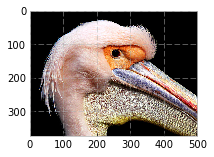

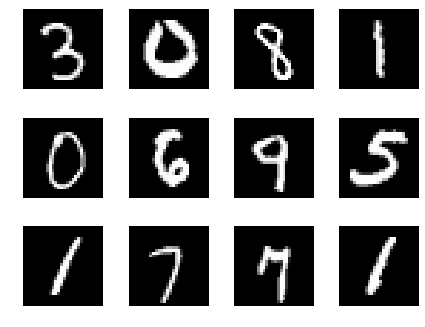

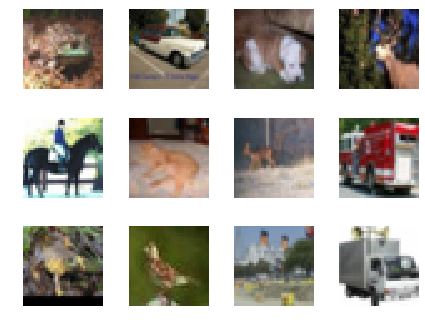

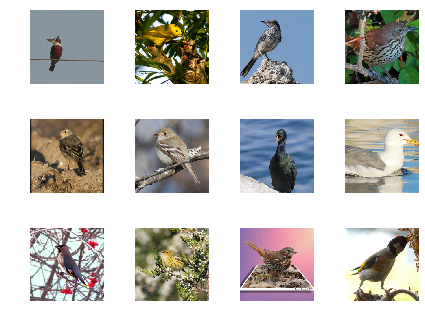

In [316]:
def plot_np_array(arr_img, fs=(3,3)):
    plt.figure(figsize=fs)
    plt.imshow(arr_img.astype('uint8'))
    plt.show()

def plot_tensor(tns_img, fs=(3,3)):
    "Takes a normalized tensor [0,1] and plots PIL image"
    pil_from_tns = transforms.ToPILImage()(tns_img)
    plt.figure(figsize=fs)
    plt.imshow(pil_from_tns)
    plt.show()

def plot_pil(pil_img, fs=(3,3)):
    plt.figure(figsize=fs)
    plt.imshow(pil_img)
    plt.show()

def imshow(inp, mean_arr, std_arr, title=None):
    # Input is normalized Tensor or Numpy Arr
    if inp.size(0) == 1:
        inp = np.squeeze(inp.numpy())
        kwargs = {'cmap':'gray'}
    else:
        inp = inp.numpy().transpose((1, 2, 0))
        kwargs = {}
    inp = std_arr * inp + mean_arr
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_preds(model, data_loader, class_names, mean_arr, std_arr, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy()
        labels = labels.data.cpu().numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('P: {}, A:{}'.format(class_names[preds[j][0]], 
                                              class_names[labels[j]]))
            imshow(inputs.cpu().data[j], mean_arr, std_arr)

            if images_so_far == num_images:
                return
        plt.tight_layout()

def plot_bw_samples(arr, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy()
    bs = arr.shape[0]
    arr = arr.reshape(bs, 28, 28)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

def plot_samples(arr, mean, std, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy().transpose((0, 2, 3, 1))
    arr = denorm_meanstd(arr, mean, std)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()

# Test

img_path = get_random_image_path(CUB_IMGS_PATH)
plot_pil(load_img_as_pil(img_path))
plot_np_array(load_img_as_np_arr(img_path))
plot_tensor(load_img_as_tensor(img_path))
inps,targs = get_mnist_batch(12)
plot_bw_samples(inps)
inps,targs = get_cifar_batch(12)
plot_samples(inps, CIFAR_MEAN, CIFAR_STD)
inps,targs = get_cub_batch(12)
plot_samples(inps, CUB_MEAN, CUB_STD)

# Models

## Logging

In [317]:
#https://docs.python.org/3/howto/logging-cookbook.html

def get_logger(ch_log_level=logging.ERROR, 
               fh_log_level=logging.INFO):
    logging.shutdown()
    imp.reload(logging)
    logger = logging.getLogger("cheatsheet")
    logger.setLevel(logging.DEBUG)
    
    # Console Handler
    if ch_log_level:
        ch = logging.StreamHandler()
        ch.setLevel(ch_log_level)
        ch.setFormatter(logging.Formatter('%(message)s'))
        logger.addHandler(ch)
    
    # File Handler
    if fh_log_level:
        fh = logging.FileHandler('cheatsheet.log')
        fh.setLevel(fh_log_level)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        fh.setFormatter(formatter)
        logger.addHandler(fh)

    return logger

#Test
logger = get_logger() #Singleton
logger.info("LOG TO FILE")
logger.error("LOG TO FILE and CONSOLE")

logger = get_logger(ch_log_level=logging.DEBUG, 
               fh_log_level=None)
logger.debug("Init Console Logger Only")

LOG TO FILE and CONSOLE
Init Console Logger Only


## Linear

In [318]:
class LinearNetMNIST(nn.Module):
    def __init__(self):
        super(LinearNetMNIST, self).__init__()
        # Input size (bs, 784)
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x
    
class LinearNetCIFAR(nn.Module):
    def __init__(self):
        super(LinearNetCIFAR, self).__init__()
        # Input (bs, 3, 32, 32)
        # Flattened to fit linear layer (bs,32*32*3)
        self.layer1 = nn.Linear(3072, 512)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x

In [319]:
inputs, targets = get_mnist_batch(2)
net = LinearNetMNIST()
print(net(Variable(inputs)))

inputs, targets = get_cifar_batch(2)
net2 = LinearNetCIFAR()
print(net2(Variable(inputs)))

Variable containing:
 0.0770  0.1084  0.0998  0.1144  0.1470  0.0900  0.1007  0.0707  0.1040  0.0880
 0.0788  0.0986  0.1117  0.0954  0.1661  0.0854  0.1086  0.0821  0.0792  0.0941
[torch.FloatTensor of size 2x10]

Variable containing:
 0.1199  0.0983  0.0913  0.0949  0.0975  0.1015  0.0957  0.1064  0.0941  0.1004
 0.1048  0.0996  0.0911  0.1100  0.0893  0.0982  0.1085  0.1081  0.0874  0.1030
[torch.FloatTensor of size 2x10]



## CNN

Tips and Guidelines
http://cs231n.github.io/convolutional-networks/

* The input layer (that contains the image) should be divisible by 2 many times
* The conv layers should be using small filters (e.g. 3x3 or at most 5x5), using a stride of S=1, and crucially, padding the input volume with zeros in such way that the conv layer does not alter the spatial dimensions of the input. That is, when FS=3, then using P=1 will retain the original size of the input. When FS=5, P=2. For a general FS, it can be seen that P = (FS − 1)/2 preserves the input size. 
* The pool layers are in charge of downsampling the spatial dimensions of the input. Introduces zero parameters since it simply computes a fixed function of the input. The most common setting is to use max-pooling with 2x2 receptive fields (i.e. FS=2), and with a stride of 2 (i.e. S=2). Output dimensions equal W2 = (W1 − FS)/S + 1.

### Basic CNN

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, logger=None):
        super(BasicCNN, self).__init__()
        self.logger = logger

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=2, stride=1, padding=0)
        self.linear = nn.Linear(in_features=100*30*30, out_features=10)
        self.softmax = nn.Softmax()
    
    def log(self, msg):
        if self.logger:
            self.logger.debug(msg)

    def forward(self, x):
        self.log(x.size()) # (bs,3,32,32)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # (bs,100*30*30)
        x = self.linear(x)
        x = self.softmax(x)
        return x

### Deeper CNN

In [320]:
class DeeperCNN(nn.Module):
    def __init__(self, logger=None):
        super(DeeperCNN, self).__init__()
        self.logger = logger 
        # Conv Dims - W2 = (W1-FS+2P)/S + 1)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64, momentum=0.9)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=128, momentum=0.9)
        self.relu2 = nn.ReLU()
        # Pool Dims - W2 = (W1 − FS)/S + 1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #shrinks by half
        self.linear1 = nn.Linear(in_features=128*16*16, out_features=512)
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(in_features=512, out_features=10)
        self.softmax = nn.Softmax()
    
    def log(self, msg):
        if self.logger:
            self.logger.debug(msg)

    def forward(self, x):
        self.log(x.size())
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)        
        x = self.softmax(x)
        return x

In [321]:
logger = get_logger(logging.DEBUG, logging.DEBUG)
net = BasicCNN(logger)
inputs,targets = next(iter(cifar_train_loader))
inputs = Variable(inputs[:2])
net(inputs)

net = DeeperCNN(logger)
inputs,targets = next(iter(cifar_train_loader))
inputs = Variable(inputs[:2])
net(inputs)

torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 32, 32])


Variable containing:
 0.0932  0.0914  0.0865  0.1224  0.1126  0.0863  0.1282  0.1042  0.0804  0.0947
 0.1803  0.0676  0.0626  0.1270  0.1028  0.1126  0.1080  0.0762  0.0706  0.0923
[torch.FloatTensor of size 2x10]

## RNN

In [322]:
# TODO

## GAN

In [323]:
# TODO

## Finetuning

* http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

### Pretrained Model

In [412]:
# Get DenseNet trained on Imagenet
densenet = models.densenet121(pretrained=True)
    
# Replace final layer with new output layer
last_layer_n_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(last_layer_n_features, len(CIFAR_CLASSES))
print(densenet.classifier)

Linear (1024 -> 10)


### Freeze Layers

In [411]:
# Freeze layers to avoid retraining
# To create a "Feature Extractor"
for param in densenet.parameters():
    param.requires_grad = False

### Reuse Specific Layers

In [410]:
vgg = models.vgg16(pretrained=True)

class MyNewModel(nn.Module):
    def __init__(self):
        super(MyNewModel, self).__init__()
        self.features = nn.Sequential(
            # stop after 5th Conv2d layer
            *list(vgg.features.children())[:11])

    def forward(self, x):
        x = self.features(x)
        return x

print(MyNewModel())

MyNewModel (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


# Training

## Methods

In [324]:
def train(net, dataloader, criterion, optimizer, epoch=1):
    net.train()
    n_batches = len(dataloader)
    total_loss = 0
    total_acc = 0
    for inputs,targets in dataloader:
        inputs = Variable(inputs.cuda())
        targets = Variable(targets.cuda())
        
        ## Forward Pass
        output = net(inputs)
        
        ## Clear Gradients
        net.zero_grad()
        
        loss = criterion(output, targets)
    
        ## Backprop
        loss.backward()
        optimizer.step()
    
        preds = get_predictions(output)
        accuracy = get_accuracy(preds, targets.data.cpu().numpy())
    
        total_loss += loss.data[0]
        total_acc += accuracy
    
    mean_loss = total_loss / n_batches
    mean_acc = total_acc / n_batches
    return mean_loss, mean_acc

def get_predictions(model_output):
    # Flatten and Get ArgMax to compute accuracy
    val,idx = torch.max(model_output, dim=1)
    return idx.data.cpu().view(-1).numpy()

def get_accuracy(preds, targets):
    correct = np.sum(preds==targets)
    return correct / len(targets)

def test(net, test_loader, criterion, epoch=1):
    net.eval()
    test_loss = 0
    test_acc = 0
    for data, target in test_loader:
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        output = net(data)
        test_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        test_acc += get_accuracy(pred, target.data.cpu().numpy())
    test_loss /= len(test_loader) #n_batches
    test_acc /= len(test_loader)
    return test_loss, test_acc

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially 
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

## MNIST

In [325]:
# Linear Model
mnistnet = LinearNetMNIST().cuda()

N_EPOCHS = 5
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(mnistnet.parameters(), lr=1e-4)

In [326]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
for epoch in range(1, N_EPOCHS+1):
    trn_loss, trn_acc = train(mnistnet, mnist_train_loader, criterion, optimizer, epoch)
    test_loss, test_acc = test(mnistnet, mnist_test_loader, criterion, epoch)
    print('Epoch %d, TrainLoss: %.3f, TrainAcc: %.3f, TestLoss: %.3f, TestAcc: %.3f' % (
        epoch, trn_loss, trn_acc, test_loss, test_acc))
    train_loss_history.append(trn_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(trn_acc)
    test_acc_history.append(test_acc)

Epoch 1, TrainLoss: 1.669, TrainAcc: 0.832, TestLoss: 1.558, TestAcc: 0.916
Epoch 2, TrainLoss: 1.556, TrainAcc: 0.915, TestLoss: 1.547, TestAcc: 0.921
Epoch 3, TrainLoss: 1.546, TrainAcc: 0.921, TestLoss: 1.542, TestAcc: 0.924
Epoch 4, TrainLoss: 1.541, TrainAcc: 0.925, TestLoss: 1.538, TestAcc: 0.926
Epoch 5, TrainLoss: 1.537, TrainAcc: 0.928, TestLoss: 1.538, TestAcc: 0.926


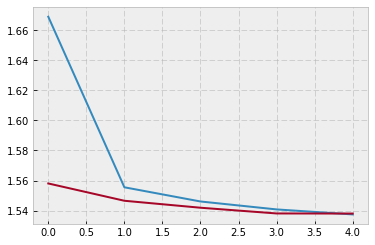

In [327]:
plt.plot(np.stack([train_loss_history, test_loss_history],1))

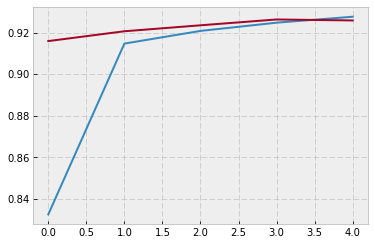

In [328]:
plt.plot(np.stack([train_acc_history, test_acc_history], 1))

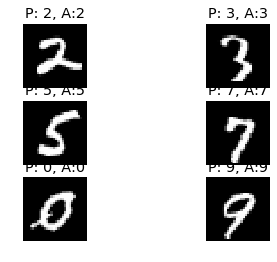

In [329]:
visualize_preds(mnistnet, mnist_test_loader, MNIST_CLASSES, MNIST_MEAN, MNIST_STD, 6)

## CIFAR

In [330]:
# Linear Model
cifarnet = LinearNetCIFAR().cuda()

# Basic CNN
cifarnet = BasicCNN().cuda()

# Deeper CNN
cifarnet = DeeperCNN().cuda()

N_EPOCHS = 5
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(cifarnet.parameters(), lr=1e-4)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in cifarnet.parameters()])))

  + Number of params: 16858890


In [331]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
for epoch in range(1, N_EPOCHS+1):
    trn_loss, trn_acc = train(cifarnet, cifar_train_loader, criterion, optimizer, epoch)
    test_loss, test_acc = test(cifarnet, cifar_test_loader, criterion, epoch)
    print('Epoch %d, TrainLoss: %.3f, TrainAcc: %.3f, TestLoss: %.3f, TestAcc: %.3f' % (
        epoch, trn_loss, trn_acc, test_loss, test_acc))
    train_loss_history.append(trn_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(trn_acc)
    test_acc_history.append(test_acc)

Epoch 1, TrainLoss: 2.178, TrainAcc: 0.277, TestLoss: 2.098, TestAcc: 0.360
Epoch 2, TrainLoss: 2.099, TrainAcc: 0.358, TestLoss: 2.038, TestAcc: 0.420
Epoch 3, TrainLoss: 2.060, TrainAcc: 0.398, TestLoss: 2.004, TestAcc: 0.455
Epoch 4, TrainLoss: 2.034, TrainAcc: 0.424, TestLoss: 1.983, TestAcc: 0.475
Epoch 5, TrainLoss: 2.016, TrainAcc: 0.442, TestLoss: 1.982, TestAcc: 0.477


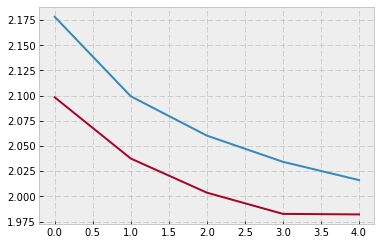

In [332]:
plt.plot(np.stack([train_loss_history, test_loss_history],1))

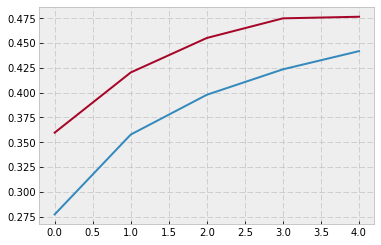

In [333]:
plt.plot(np.stack([train_acc_history, test_acc_history], 1))

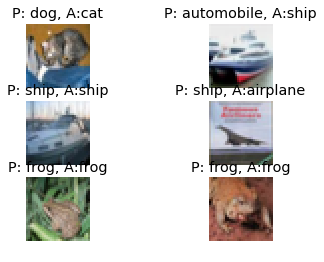

In [334]:
visualize_preds(cifarnet, cifar_test_loader, CIFAR_CLASS_NAMES, CIFAR_MEAN, CIFAR_STD, 6)

# Experiments

## Load/Save Weights

In [342]:
def save_weights(model, weights_dir, epoch):
    weights_fname = 'weights-%d.pth' % (epoch)
    weights_fpath = os.path.join(weights_dir, weights_fname)
    torch.save({'state_dict': model.state_dict()}, weights_fpath)

def load_weights(model, fpath):
    state = torch.load(fpath)
    model.load_state_dict(state['state_dict'])

# Test
model = LinearNetCIFAR()
save_weights(model, MNIST_WEIGHTS_PATH, 1)
load_weights(model, MNIST_WEIGHTS_PATH+'weights-1.pth')

## Visdom Web Server

In [343]:
# Real-time visualizations in your browser
# https://github.com/facebookresearch/visdom

import visdom
viz = visdom.Visdom()

In [344]:
def viz_plot_tst_trn(window, epoch, tst_val, trn_val, name='loss', env='main'):
    if window is None:
        return viz.line(
            X=np.array([epoch]),
            Y=np.array([[tst_val, trn_val]]),
            opts=dict(
                xlabel='epoch',
                ylabel=name,
                title=env+' '+name,
                legend=['Validation', 'Train']
            ),
            env=env
        )
    return viz.line(
        X=np.ones((1, 2)) * epoch,
        Y=np.expand_dims([tst_val, trn_val],0),
        win=window,
        update='append',
        env=env
    )

def viz_plot_img(window, arr, mean, std, env='main', title='Image'):
    '''
    This function draws an img on your Visdom web app. 
    It takes as input an `CxHxW` tensor `img`
    The array values can be float in [0,1] or uint8 in [0, 255]'''
    if type(arr) is not np.ndarray:
        arr = arr.numpy().transpose((1, 2, 0))
    arr = denorm_meanstd(arr, mean, std)
    arr = arr.transpose((2, 0, 1))
    viz.image(
        arr,
        opts=dict(title=title, caption='Silly image'),
        win=window,
        env=env
    )
    
def viz_plot_text(window, text, env='main'):
    if window is None:
        return viz.text(
            text,
            env=env
        )
    return viz.text(
        text,
        win=window,
        env=env
    )

def viz_plot_summary(window, epoch, tst_loss, trn_loss,
                       tst_err, trn_err, env='main'):
    txt = ("""Epoch: %d
        Train - Loss: %.3f Err: %.3f
        Test - Loss: %.3f Err: %.3f""" % (epoch, 
        trn_loss, trn_err, tst_loss, tst_err))
    return viz_plot_text(window, txt, env)

In [345]:
#Visit http://localhost:8097 to view plots

#Should plot one chart and update it
txt_chart = viz_plot_summary(None, 1, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 3, 8, 7, 6)

#Should plot one chart and update it
sum_chart = viz_plot_text(None, 'Hello, world3!')
sum_chart = viz_plot_text(sum_chart, 'Hello, world4!')

#Should plot one chart and update it
#window, epoch, tst_val, trn_val, name='loss', env='main'
loss_chart = viz_plot_tst_trn(None, 9, 14, 27, 'loss')
loss_chart = viz_plot_tst_trn(loss_chart, 10, 18, 30, 'loss')
loss_chart = viz_plot_tst_trn(loss_chart, 11, 19, 32, 'loss')

#Should plot one chart and update it
#window, epoch, tst_val, trn_val, name='loss', env='main'
err_chart = viz_plot_tst_trn(None, 9, 14, 27, 'error')
err_chart = viz_plot_tst_trn(err_chart, 10, 18, 30, 'error')
err_chart = viz_plot_tst_trn(err_chart, 11, 19, 32, 'error')

# Plot Image
inputs, targets = next(iter(cifar_train_loader))
img_chart = viz.image(
    np.random.rand(3,100,100),
    opts=dict(title="Image", caption='Silly random'),
)
viz_plot_img(img_chart, inputs[0], CIFAR_MEAN, CIFAR_STD)

## Experiment Class

In [346]:
import numpy as np
import os
import torch
import visdom
import shutil
import sys
from pathlib import Path


class Experiment():
    def __init__(self, name, root, logger=None):
        self.name = name
        self.root = os.path.join(root,name)
        self.logger = logger
        self.epoch = 1
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 1
        self.weights_dir = os.path.join(self.root, 'weights')
        self.history_dir = os.path.join(self.root, 'history')
        self.results_dir = os.path.join(self.root, 'results')
        self.latest_weights = os.path.join(self.weights_dir, 'latest_weights.pth')
        self.latest_optimizer = os.path.join(self.weights_dir, 'latest_optim.pth')
        self.best_weights_path = self.latest_weights
        self.best_optimizer_path = self.latest_optimizer
        self.train_history_fpath = os.path.join(self.history_dir, 'train.csv')
        self.val_history_fpath = os.path.join(self.history_dir, 'val.csv')
        self.test_history_fpath = os.path.join(self.history_dir, 'test.csv')
        self.loss_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.acc_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.viz = visdom.Visdom()
        self.visdom_plots = self.init_visdom_plots()

    def log(self, msg):
        if self.logger:
            logger.info(msg)
        
    def init(self):
        self.log("Creating new experiment")
        self.init_dirs()
        self.init_history_files()

    def resume(self, model, optim, weights_fpath=None, optim_path=None):
        self.log("Resuming existing experiment")
        if weights_fpath is None:
            weights_fpath = self.latest_weights
        if optim_path is None:
            optim_path = self.latest_optimizer

        model, state = self.load_weights(model, weights_fpath)
        optim = self.load_optimizer(optim, optim_path)

        self.best_val_loss = state['best_val_loss']
        self.best_val_loss_epoch = state['best_val_loss_epoch']
        self.epoch = state['last_epoch']+1
        self.load_history_from_file('train')
        self.load_history_from_file('val')

        return model, optim

    def init_dirs(self):
        os.makedirs(self.weights_dir)
        os.makedirs(self.history_dir)
        os.makedirs(self.results_dir)

    def init_history_files(self):
        Path(self.train_history_fpath).touch()
        Path(self.val_history_fpath).touch()
        Path(self.test_history_fpath).touch()

    def init_visdom_plots(self):
        loss = self.init_viz_train_plot('loss')
        accuracy = self.init_viz_train_plot('accuracy')
        summary = self.init_viz_txt_plot('summary')
        return {
            'loss':loss,
            'accuracy':accuracy,
            'summary':summary
        }

    def init_viz_train_plot(self, title):
        return self.viz.line(
            X=np.array([1]),
            Y=np.array([[1, 1]]),
            opts=dict(
                xlabel='epoch',
                ylabel=title,
                title=self.name+' '+title,
                legend=['Train', 'Validation']
            ),
            env=self.name
        )

    def init_viz_txt_plot(self, title):
        return self.viz.text(
            "Initializing.. " + title,
            env=self.name
        )

    def viz_epochs(self):
        epochs = np.arange(1,self.epoch+1)
        return np.stack([epochs, epochs],1)

    def update_viz_loss_plot(self):
        loss = np.stack([self.loss_history['train'],
                         self.loss_history['val']],1)
        window = self.visdom_plots['loss']
        return self.viz.line(
            X=self.viz_epochs(),
            Y=loss,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='loss',
                title=self.name+' '+'loss',
                legend=['Train', 'Validation']
            ),
        )

    def update_viz_acc_plot(self):
        acc = np.stack([self.acc_history['train'],
                         self.acc_history['val']], 1)
        window = self.visdom_plots['accuracy']
        return self.viz.line(
            X=self.viz_epochs(),
            Y=acc,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='accuracy',
                title=self.name+' '+'accuracy',
                legend=['Train', 'Validation']
            )
        )

    def update_viz_summary_plot(self):
        trn_loss = self.loss_history['train'][-1]
        val_loss = self.loss_history['val'][-1]
        trn_acc = self.acc_history['train'][-1]
        val_acc = self.acc_history['val'][-1]
        txt = ("""Epoch: %d
            Train - Loss: %.3f Acc: %.3f
            Test - Loss: %.3f Acc: %.3f""" % (self.epoch,
            trn_loss, trn_acc, val_loss, val_acc))
        window = self.visdom_plots['summary']
        return self.viz.text(
            txt,
            win=window,
            env=self.name
        )

    def load_history_from_file(self, dset_type):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        data = np.loadtxt(fpath, delimiter=',').reshape(-1, 3)
        self.loss_history[dset_type] = data[:,1]
        self.acc_history[dset_type] = data[:,2]

    def append_history_to_file(self, dset_type, loss, acc):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        with open(fpath, 'a') as f:
            f.write('{},{},{}\n'.format(self.epoch, loss, acc))

    def save_history(self, dset_type, loss, acc):
        self.loss_history[dset_type] = np.append(
            self.loss_history[dset_type], loss)
        self.acc_history[dset_type] = np.append(
            self.acc_history[dset_type], acc)
        self.append_history_to_file(dset_type, loss, acc)

        if dset_type == 'val' and self.is_best_loss(loss):
            self.best_val_loss = loss
            self.best_val_loss_epoch = self.epoch

    def is_best_loss(self, loss):
        return loss < self.best_val_loss

    def save_weights(self, model, trn_loss, val_loss, trn_acc, val_acc):
        weights_fname = self.name+'-weights-%d-%.3f-%.3f-%.3f-%.3f.pth' % (
            epoch, trn_loss, trn_acc, val_loss, val_acc)
        weights_fpath = os.path.join(self.weights_dir, weights_fname)
        torch.save({
                'last_epoch': self.epoch,
                'trn_loss': trn_loss,
                'val_loss': val_loss,
                'trn_acc': trn_acc,
                'val_acc': val_acc,
                'best_val_loss': self.best_val_loss,
                'best_val_loss_epoch': self.best_val_loss_epoch,
                'experiment': self.name,
                'state_dict': model.state_dict()
            }, weights_fpath )
        shutil.copyfile(weights_fpath, self.latest_weights)
        if self.is_best_loss(val_loss):
            self.best_weights_path = weights_fpath

    def load_weights(self, model, fpath):
        self.log("loading weights '{}'".format(fpath))
        state = torch.load(fpath)
        model.load_state_dict(state['state_dict'])
        self.log("loaded weights from experiment %s (last_epoch %d, trn_loss %s, trn_acc %s, val_loss %s, val_acc %s)" % (
                  self.name, state['last_epoch'], state['trn_loss'],
                    state['trn_acc'], state['val_loss'], state['val_acc']))
        return model, state

    def save_optimizer(self, optimizer, val_loss):
        optim_fname = self.name+'-optim-%d.pth' % (epoch)
        optim_fpath = os.path.join(self.weights_dir, optim_fname)
        torch.save({
                'last_epoch': self.epoch,
                'experiment': self.name,
                'state_dict': optimizer.state_dict()
            }, optim_fpath )
        shutil.copyfile(optim_fpath, self.latest_optimizer)
        if self.is_best_loss(val_loss):
            self.best_optimizer_path = optim_path

    def load_optimizer(self, optimizer, fpath):
        self.log("loading optimizer '{}'".format(fpath))
        optim = torch.load(fpath)
        optimizer.load_state_dict(optim['state_dict'])
        self.log("loaded optimizer from session {}, last_epoch {}"
              .format(optim['experiment'], optim['last_epoch']))
        return optim
    
    def plot_and_save_history(self):
        trn_data = np.loadtxt(self.train_history_fpath, delimiter=',').reshape(-1, 3)
        val_data = np.loadtxt(self.val_history_fpath, delimiter=',').reshape(-1, 3)
        
        trn_epoch, trn_loss, trn_acc = np.split(trn_data, [1,2], axis=1)
        val_epoch, val_loss, val_acc = np.split(val_data, [1,2], axis=1)

        # Loss
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        plt.plot(trn_epoch, trn_loss, label='Train')
        plt.plot(val_epoch, val_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        ax.set_yscale('log')
        loss_fname = os.path.join(self.history_dir, 'loss.png')
        plt.savefig(loss_fname)

        # Accuracy
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        plt.plot(trn_epoch, trn_acc, label='Train')
        plt.plot(val_epoch, val_acc, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        ax.set_yscale('log')
        plt.legend()
        acc_fname = os.path.join(self.history_dir, 'accuracy.png')
        plt.savefig(acc_fname)

        # Combined View - loss-accuracy.png
        loss_acc_fname = os.path.join(self.history_dir, 'loss-acc.png')
        os.system('convert +append {} {} {}'.format(loss_fname, acc_fname, loss_acc_fname))


## New Experiment

In [347]:
N_EPOCHS = 5
MAX_PATIENCE = 50
LEARNING_RATE = 1e-4
LR_DECAY = 0.995
DECAY_LR_EVERY_N_EPOCHS = 1
EXPERIMENT_NAME = 'cifarexp1'

logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.INFO)
model = DeeperCNN(logger).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
exp = Experiment(EXPERIMENT_NAME, CIFAR10_PATH, logger)

# Create New Experiment
exp.init()

Creating new experiment


  + Number of params: 16858890


FileExistsError: [Errno 17] File exists: '/media/bfortuner/bigguy/data/cifar10/cifarexp1/weights'

In [348]:
for epoch in range(exp.epoch, exp.epoch+N_EPOCHS):
    since = time.time()

    ### Train ###
    trn_loss, trn_acc = train(model, cifar_train_loader, criterion, optimizer, epoch)
    logger.info('Epoch {:d}: Train - Loss: {:.4f}\tAcc: {:.4f}'.format(epoch, trn_loss, trn_acc))    
    time_elapsed = time.time() - since  
    logger.info('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss, val_acc = test(model, cifar_test_loader, criterion, epoch)    
    logger.info('Val - Loss: {:.4f}, Acc: {:.4f}'.format(val_loss, val_acc))
    time_elapsed = time.time() - since  
    logger.info('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Save Metrics ###
    exp.save_history('train', trn_loss, trn_acc)
    exp.save_history('val', val_loss, val_acc)
    
    ### Checkpoint ###    
    exp.save_weights(model, trn_loss, val_loss, trn_acc, val_acc)
    exp.save_optimizer(optimizer, val_loss)
    
    ### Plot Online ###
    exp.update_viz_loss_plot()
    exp.update_viz_acc_plot()
    exp.update_viz_summary_plot()
    
    ## Early Stopping ##
    if (epoch - exp.best_val_loss_epoch) > MAX_PATIENCE:
        logger.info(("Early stopping at epoch %d since no " 
               + "better loss found since epoch %.3") 
               % (epoch, exp.best_val_loss))
        break

    ### Adjust Lr ###
    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer, 
                         epoch, DECAY_LR_EVERY_N_EPOCHS)
    
    exp.epoch += 1

Epoch 1: Train - Loss: 2.1817	Acc: 0.2734
Train Time 0m 15s
Val - Loss: 2.1180, Acc: 0.3380
Total Time 0m 16s

Epoch 2: Train - Loss: 2.1263	Acc: 0.3315
Train Time 0m 15s
Val - Loss: 2.1134, Acc: 0.3449
Total Time 0m 16s

Epoch 3: Train - Loss: 2.1051	Acc: 0.3527
Train Time 0m 15s
Val - Loss: 2.0922, Acc: 0.3660
Total Time 0m 16s

Epoch 4: Train - Loss: 2.0904	Acc: 0.3673
Train Time 0m 15s
Val - Loss: 2.0617, Acc: 0.3964
Total Time 0m 16s

Epoch 5: Train - Loss: 2.0538	Acc: 0.4045
Train Time 0m 15s
Val - Loss: 1.9987, Acc: 0.4609
Total Time 0m 16s



## Resume Experiment

Resuming existing experiment
loading weights '/media/bfortuner/bigguy/data/cifar10/cifarexp1/weights/latest_weights.pth'
loaded weights from experiment cifarexp1 (last_epoch 5, trn_loss 2.0538487835308477, trn_acc 0.404511668798, val_loss 1.9986905097961425, val_acc 0.460883689413)
loading optimizer '/media/bfortuner/bigguy/data/cifar10/cifarexp1/weights/latest_optim.pth'
loaded optimizer from session cifarexp1, last_epoch 5


LOSS 1.9986905097961425 ACC 0.460883689413


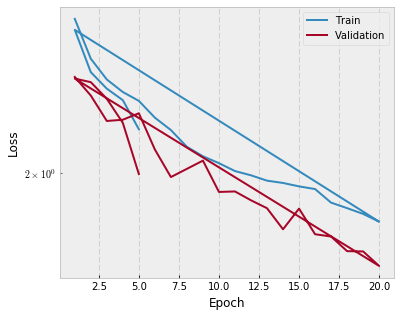

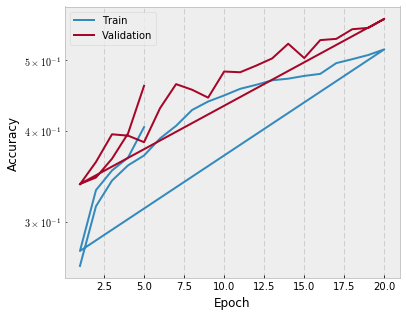

In [349]:
logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.INFO)
model = DeeperCNN(logger).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
exp = Experiment(EXPERIMENT_NAME, CIFAR10_PATH, logger)

#Load saved weights and optimizer
model, optimizer = exp.resume(model, optimizer)

loss,acc = test(model, cifar_test_loader, criterion, exp.epoch)
print("LOSS",str(loss),"ACC",str(acc))
exp.plot_and_save_history()

# Resources

## Tutorials

* [Official Pytorch Tutorials](http://pytorch.org/tutorials/)
* [Pytorch Documentation](http://pytorch.org/docs)

## Examples

### CNNs

 * [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py)
 * [ResNet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)
 * [InceptionNet](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)
 * [SqeezeNet](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)
 * [DenseNet](https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py)
 * [FCDenseNet (Tiramisu)](https://github.com/bfortuner/pytorch_tiramisu/blob/master/tiramisu-pytorch.ipynb)
 * [Sub-pixel CNN (superresolution)](https://github.com/pytorch/examples/tree/master/super_resolution)

### GANs

* [DCGAN](https://github.com/pytorch/examples/tree/master/dcgan)
* [Wasserstein GAN](https://github.com/martinarjovsky/WassersteinGAN)

### RNNs

### Other

* [Pytorch Examples](https://github.com/pytorch/examples)